# Idealized entrainment

This notebook visualizes the results of GOTM simulations in an idealized wind stress-driven entrainment case with no rotation, in which the mixed layer gradually entrains into an underlying non-turbulent region with constant stable stratification.
The results are compared with the scaling derived from laboratory experiments of [Price (1979)](https://doi.org/10.1017/S0022112079002366), in which the time evolution of the mixed layer depth follows

$h_m(t) = (2R_v)^{1/4}u_*\left(\frac{t}{N_0}\right)^{1/2}$

where $R_v\approx0.6$ is the bulk Richardson number, $u_*$ the water side surface friction velocity, $N_0$ the initial buoyancy frequency.
See, e.g., section 5.1 of [Umlauf and Burchard (2005)](https://doi.org/10.1016/j.csr.2004.08.004) for more details.

In [1]:
import sys
import numpy as np
import string
import matplotlib.pyplot as plt
from matplotlib import cm
# add the path of gotmtool
sys.path.append("../gotmtool")
from gotmtool import *
from gotmtool.diags import *

## Load data

In [2]:
casenames = ['KPP-CVMix', 'KPPLT-LF17']
labels = {'KPP-CVMix': 'KPP-CVMix', 'KPPLT-LF17': 'KPPLT-LF17',}
colors = {'KPP-CVMix': 'k', 'KPPLT-LF17': 'gray'}
markers = {'KPP-CVMix': 'x', 'KPPLT-LF17': 'x'}
nkpp = len(casenames)
title = 'KC04-MY'
e6list = [1.0, 4.0, 6.0, 7.0]
cmap = cm.get_cmap('rainbow')
ifrac = np.linspace(0, 1, len(e6list))             
for i, e6 in enumerate(e6list):
    casenames.append('KC04-MY-e6-{:.1f}'.format(e6))
    labels[casenames[i+nkpp]] = '$e_6$={:.1f}'.format(e6)
    colors[casenames[i+nkpp]] = cmap(ifrac[i])
    markers[casenames[i+nkpp]] = 'o'

casenames.append('KC04-MY-NS')
labels[casenames[-1]] = 'w/o Stokes'
colors[casenames[-1]] = 'k'
markers[casenames[-1]] = 'o'

casedir = '../gotm/run/Entrainment-KC04'
casedir0 = '../Entrainment'
for cn in ['KPP-CVMix', 'KPPLT-LF17']:
    if not os.path.islink(os.path.join(casedir, cn)):
        os.symlink(os.path.join(casedir0, cn), os.path.join(casedir, cn))
save_fig = True

In [3]:
labels

{'KPP-CVMix': 'KPP-CVMix',
 'KPPLT-LF17': 'KPPLT-LF17',
 'KC04-MY-e6-1.0': '$e_6$=1.0',
 'KC04-MY-e6-4.0': '$e_6$=4.0',
 'KC04-MY-e6-6.0': '$e_6$=6.0',
 'KC04-MY-e6-7.0': '$e_6$=7.0',
 'KC04-MY-NS': 'w/o Stokes'}

In [4]:
sims = {}
dataset = {}
for case in casenames:
    sim = Simulation(path=casedir+'/'+case)
    sims[case] = sim
    dataset[case] = sim.load_data()

## Figure

A comparison of the time evolution of the mixed layer depth $h_m$ in GOTM simulations defined by the depth at which $N^2$ reaches its maximum in colored symbols, and the prediction of [Price (1979)](https://doi.org/10.1017/S0022112079002366) in black line.

First, compute the predicted mixed layer depth.

In [5]:
data0 = dataset[casenames[0]]
N0 = np.sqrt(data0.NN[2,-1,0,0].values)
ustar = data0.u_taus[-1,0,0].values
sec = ((data0.time - data0.time[0])/np.timedelta64(1, 's')).values
mld_val = np.sqrt(np.sqrt(2.*0.6))*ustar*np.sqrt(sec/N0)
mld_p79 = xr.DataArray(mld_val, dims=['time'], coords={'time': data0.time},  
                  attrs={'long_name': 'mixed layer depth (Price 1979)',
                        'units': 'm'})

Then, plot the figure. See also Fig. 5a of [Umlauf and Burchard (2005)](https://doi.org/10.1016/j.csr.2004.08.004).

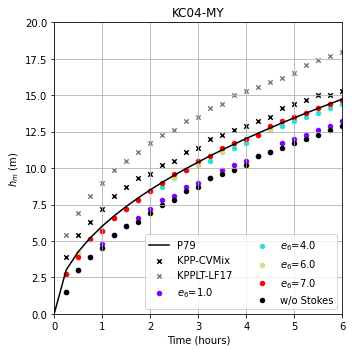

In [6]:
fig = plt.figure(figsize=[5,5])
hours = sec/3600.
plt.plot(hours, mld_p79.values, color='k', linestyle='-', linewidth=1.5, label='P79')
for case in casenames:
    data = dataset[case]
    NN = data.NN[:,:,0,0]
    mld = get_bld_maxNN(NN)
    plt.scatter(hours, mld.values, s=20, color=colors[case], marker=markers[case], label=labels[case])
plt.ylabel('$h_m$ (m)')
plt.xlabel('Time (hours)')
plt.title(title)
plt.xlim([hours[0], hours[-1]])
plt.ylim([0,20])
plt.legend(loc='lower right', ncol=2)
plt.grid()
if save_fig:
    plt.tight_layout()
    figname = 'entrainment_ts_kc04-my.pdf'
    fig.savefig(figname, dpi=300)